# Initial model
Simulations for $1\leq n\leq 100$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tk
from statsmodels.distributions.empirical_distribution import ECDF

from Functions.Functions import controller_MLE
from Functions.Functions import plot_ts
from Functions.Functions import plot_CCD
from Functions.Functions import Hill
from Functions.Functions import hist
from Functions.Functions import KL

from scipy.stats import ks_2samp
import scipy.stats as sc
import scipy.special as spec
from scipy.special import kl_div
from scipy.special import rel_entr

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})

----
### 1. Parameters

In [2]:
Niter = int(1e5)
a0 = 2
var = .8

n = np.linspace(1,100,100,dtype=int)

----
### 2. Simulation

In [3]:
c = np.zeros( (Niter,len(n)) )
z = np.zeros( (Niter,len(n)) )

def controller_MLE(t,c_,z_,n=1):
    '''
    MLE estimator for one step lookback, as derived in Eurich and Pawelzik.
    Returns c_t = c_{t-1} + z_t/z_{t-1}
    '''
    if t<n:
        ct = np.sum( (c_[0:t]*(z_[0:t]**2)+z_[0:t]*z_[1:t+1])) / np.sum((z_[0:t]**2))
        #ct = 0#c_[t-1] + z[t]/z[t-1]
    else:
        ct = np.sum( (c_[t-n:t]*(z_[t-n:t]**2)+z_[t-n:t]*z_[t-n+1:t+1])) / np.sum((z_[t-n:t]**2) )
    return ct

for k,n_ in enumerate(n):
    beta = np.random.randn(Niter)
    beta = np.sqrt(var)*beta

    c[0,k]=0
    z[0,k]=1 
    z[1,k]=a0+beta[0] 
    c[1,k]=z[1,k]

    z[2,k] = (a0-c[1,k])*z[1,k] + beta[1]

    for t in range(2,Niter-1):
        z[t+1,k]=z[t,k]*(a0-c[t,k])+beta[t]
        c[t+1,k]=controller_MLE(t,c[:,k],z[:,k],n=n_) 

----
### 3. CCDF

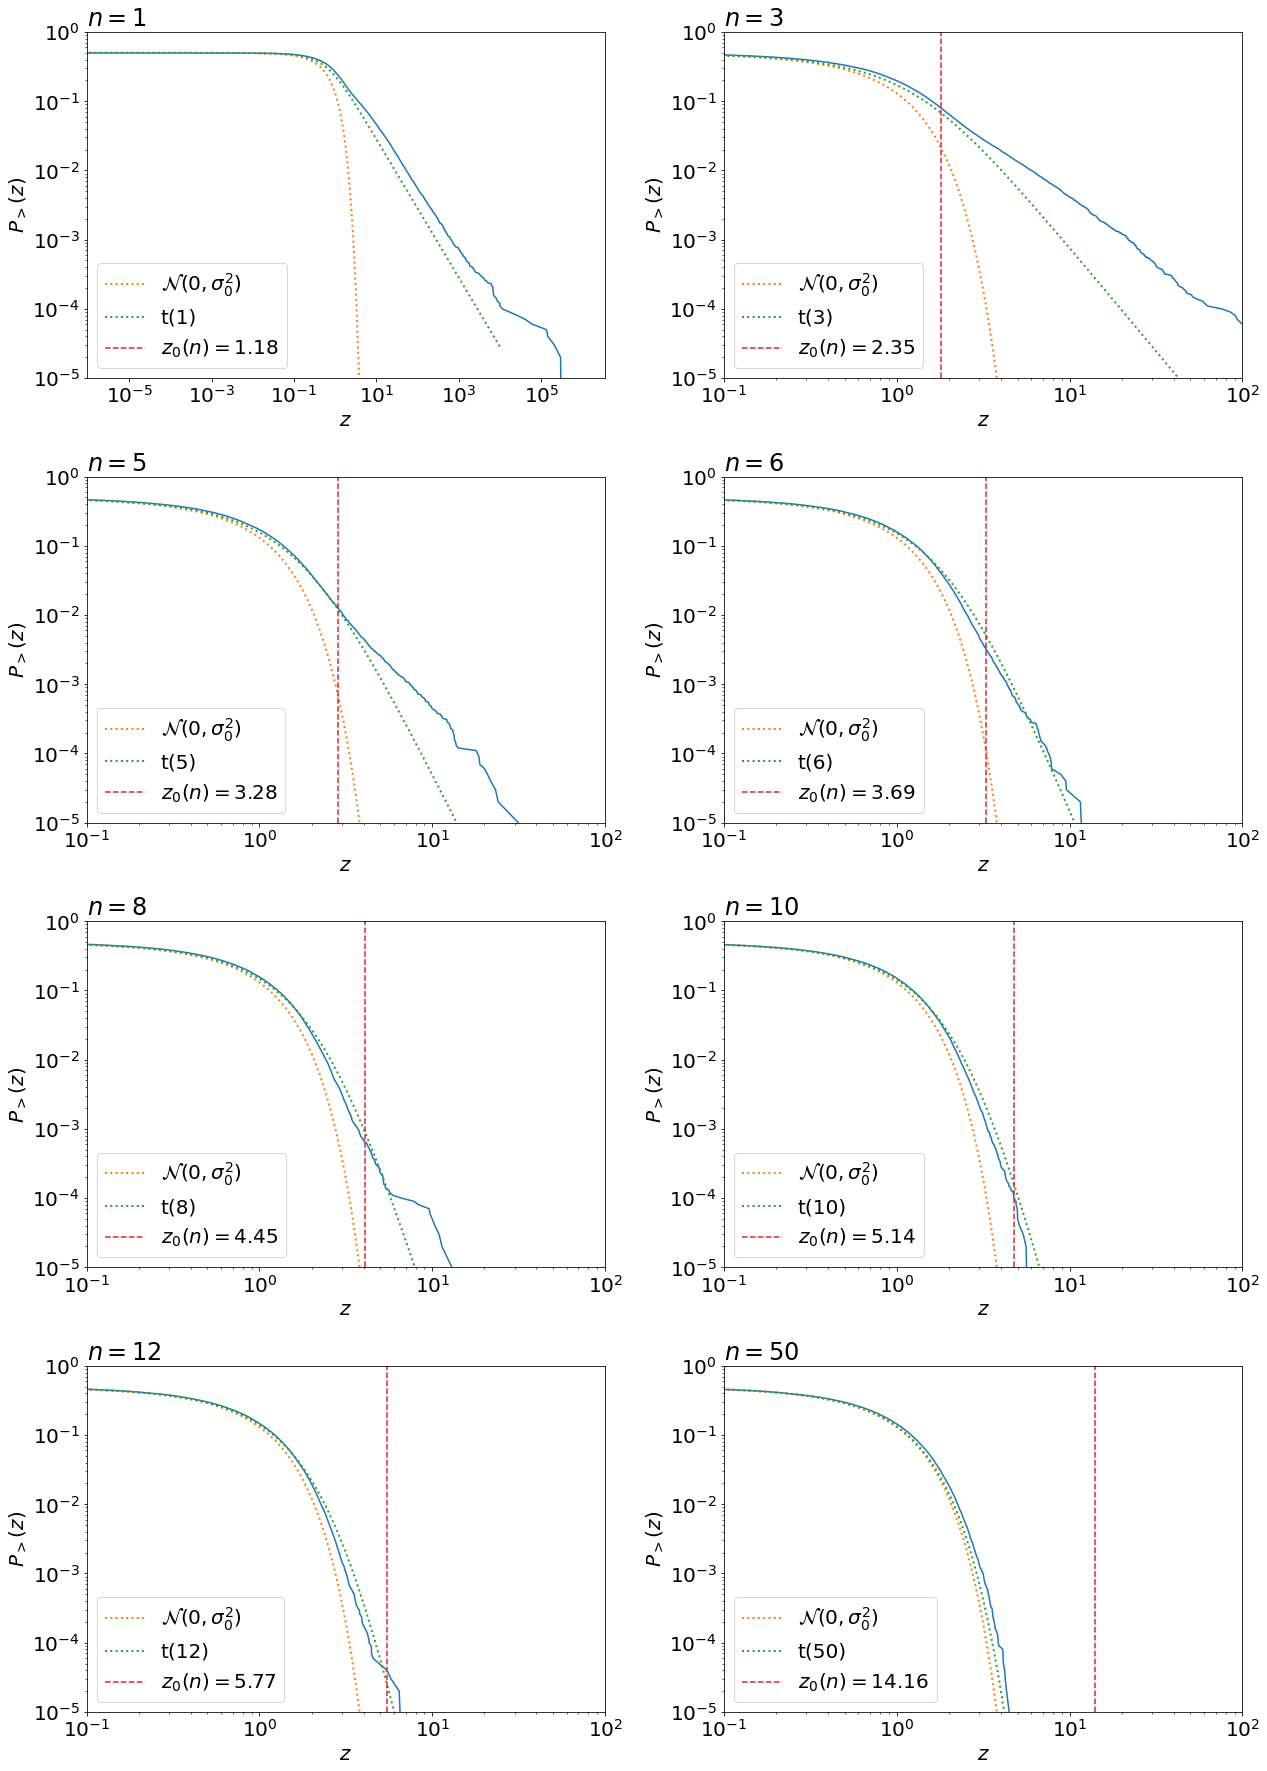

In [4]:
plt.figure(figsize=(18,25))

set_n = [1,3,5,6,8,10,12,50]
x=np.linspace(-100,1e4,int(1e6))
for k,i in enumerate(set_n):
    plt.subplot(4,2,k+1)
    ecdf = ECDF( (z[:,k]) )
    # plot the ccd
    p = plt.plot(ecdf.x, 1-ecdf.y);


    plt.plot(x,1-sc.norm.cdf(x,loc=0,scale=.89),':',label=r'$\mathcal{N}(0,\sigma_0^2)$',color='tab:orange',linewidth=2)
    plt.plot(x,1-sc.t.cdf(x,i, loc=0, scale=.89),':',label='t({:})'.format(i),color='tab:green',linewidth=2)
    
    plt.axvline(x=np.sqrt((i)*np.log((i))),linestyle='--',color='tab:red',label='$z_0(n)={:.2f}$'.format(np.sqrt((i+1)*np.log((i+1)))))

    plt.xscale('log')
    plt.yscale('log')


    plt.ylabel(r'$P_>(z)$')
    plt.xlabel(r'$z$');

    if i!=1: plt.xlim([1e-1,1e2])
    plt.ylim([1e-5,1])
    plt.legend(loc='lower left');
    plt.title('$n={:}$'.format(i),loc='left')
    
plt.tight_layout()  

#plt.savefig('GraphsR5/CCDF_n.pdf')

----
### 4. Absolute half moment, cumulants and KL Divergence

##### 1. Half moment

In [5]:
th_hm = np.sqrt(np.sqrt(2*.8)/np.pi)*spec.gamma(3/4)
hm = np.mean(np.sqrt(np.abs(z)),axis=0)

In [6]:
import scipy.stats as stats
cumulants = np.asarray([[stats.kstat(z[:,i], n=j) for i in range(len(n))] for j in range(1,5)])

##### 2. Cumulants

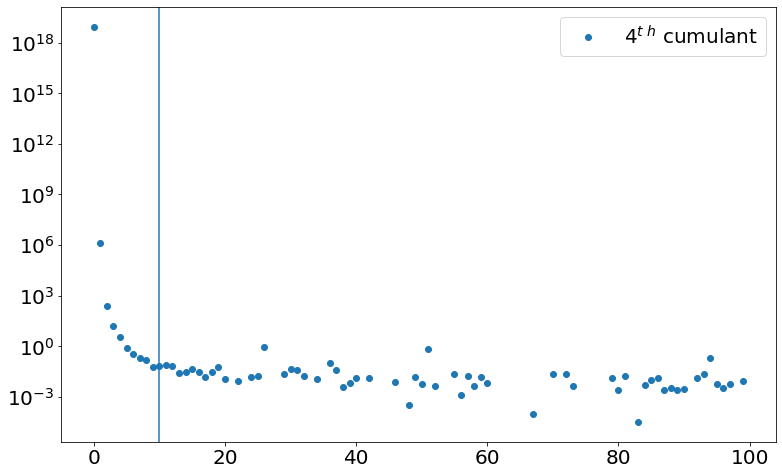

In [7]:
plt.figure(figsize=(8*1.6,8))
nc = 4
plt.plot(cumulants[nc-1,:],'o',label=r'{:}$^t\,^h$ cumulant'.format(nc));
plt.axhline(0)
plt.axvline(10)
plt.legend();
plt.yscale('log')
#plt.xscale('log')

##### 3. KL divergence

In [8]:
KL_norm = np.zeros(len(n))
KL_t = np.zeros(len(n))


for i in range(len(n)):
    #hist_z = np.histogram(z[:,i][np.abs(z[:,i])<np.sqrt(np.log(i+1))-.5],bins=10000,density=True) 
    hist_z = np.histogram(z[:,i],bins=90,density=True) 
    #x=np.linspace(np.min(z[:,i]),np.max(z[:,i]),len(hist_z[1])-1)
    #x=np.linspace(1,100,len(hist_z[1])-1)
    x = hist_z[1][:-1]
    #norm = sc.norm.pdf(x,loc=np.mean(z[:,i]), scale=np.std(z[:,i]))
    norm = sc.norm.pdf(x,loc=0, scale=np.sqrt(var))
    #
    t = sc.t.pdf(x,i+1, loc=0, scale=np.sqrt(var))
    
    KL_norm[i] = np.sum(rel_entr(hist_z[0],norm))
    KL_t[i] = np.sum(rel_entr(hist_z[0],t))


In [9]:
exp_fit = np.polyfit(1/n[3:],np.log(KL_norm[3:]),deg=1)

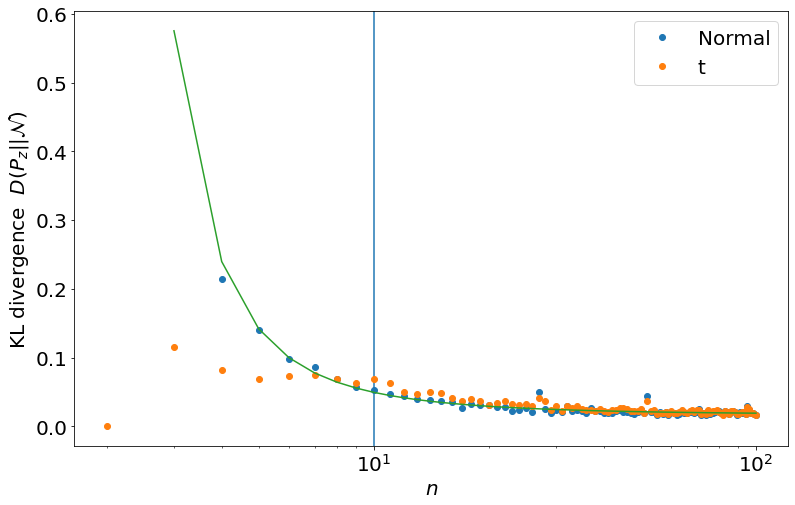

In [10]:
plt.figure(figsize=(8*1.6,8))
plt.plot(n,KL_norm,'o',label='Normal')
plt.axvline(x=10)
plt.plot(n[1:],KL_t[1:],'o',label='t');

plt.plot(n[2:],np.exp(exp_fit[0]/n[2:])*np.exp(exp_fit[1]))
plt.legend();
plt.xlabel('$n$')
plt.ylabel(r'KL divergence  $D(P_z\vert \vert \mathcal{N})$')
#plt.yscale('log')
plt.xscale('log')

In [11]:
print(exp_fit)

[10.50783729 -4.0552823 ]


##### 4. Final Plot

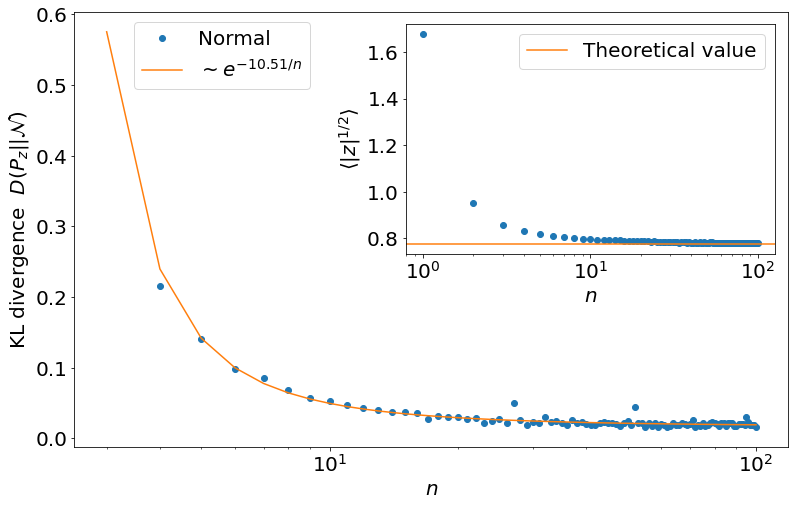

In [18]:
fig, ax1 = plt.subplots(figsize=(8*1.6,8))
#fig, ax1 = plt.subplots(figsize=(9,8))

ax1.plot(n,KL_norm,'o',label='Normal')
ax1.plot(n[2:],np.exp(exp_fit[0]/n[2:])*np.exp(exp_fit[1]),label='$\sim e^{{{:.4}/n}}$'.format(-exp_fit[0]))

ax1.set_xlabel('$n$')
ax1.set_ylabel(r'KL divergence  $D(P_z\vert \vert \mathcal{N})$')
#plt.yscale('log')
ax1.set_xscale('log')
ax1.legend( bbox_to_anchor=(0.07, 1))


#ax1.legend(loc='upper left')


left, bottom, width, height = [0.485, 0.46, 0.40, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(n,hm,'o');
#ax2.axhline(th_hm,c='tab:orange',label=r'$\mathbb{E}\left[\vert {X}\vert^{1/2}\right]$')
ax2.axhline(th_hm,c='tab:orange',label='Theoretical value')
ax2.set_xlabel('$n$')
ax2.set_ylabel(r'$\langle \vert z\vert^{1/2}\rangle $');
ax2.set_xscale('log')
ax2.legend();

#plt.savefig('GraphsR5/KL_n.png')

----
### 5. Exponent estimation
##### 1. Hill

In [14]:
delta = np.zeros_like(n,dtype=float)
C = np.zeros_like(n,dtype=float)
for j,n_test in enumerate(n[:-1]):
    OS_z = np.sort(np.abs(z[:,j]),axis=0)
    OS_z = OS_z[::-1]
    Nk = int(1e2)
    #ktest = np.logspace(0,np.log(np.max(OS_z[:,j])*.4),Nk)
    #ktest = np.linspace(1e-2,np.max(z[:,j+1])*.8,Nk)
    ktest = np.logspace(0,3,Nk)
    #ktest = np.logspace(0,1,Nk)
    mu_hill = np.zeros_like(ktest)
    c = np.zeros_like(ktest)
    
    for i,k in enumerate(ktest):
        kmin = np.argmin(OS_z[:]>k)
        mu_hill[i] = kmin/(np.sum(np.log(OS_z[:kmin]/OS_z[kmin]))) 
        c[i] = OS_z[kmin]**(mu_hill)[i]*kmin/len(OS_z)
    delta[j] = np.nanmean(mu_hill+1)
    C[j] = np.nanmean(C)

##### 2. Fit

In [15]:
mu = np.zeros((len(n),2))

cutoff = np.log(n*np.sqrt(n))
cutoff = cutoff*(np.max(z,axis=0)>cutoff)
cutoff = np.ones_like(n)*3
for i,n_ in enumerate(n):
    ecdf = ECDF( (z[:,i]-np.mean(z[:,i]))/np.std(z[:,i]))   

    mu[i] = 1-np.polyfit(np.log10(ecdf.x[ecdf.x>cutoff[i]][:-1]),np.log10(1-ecdf.y[ecdf.x>cutoff[i]][:-1]),1)[0] 

##### 3. Plot

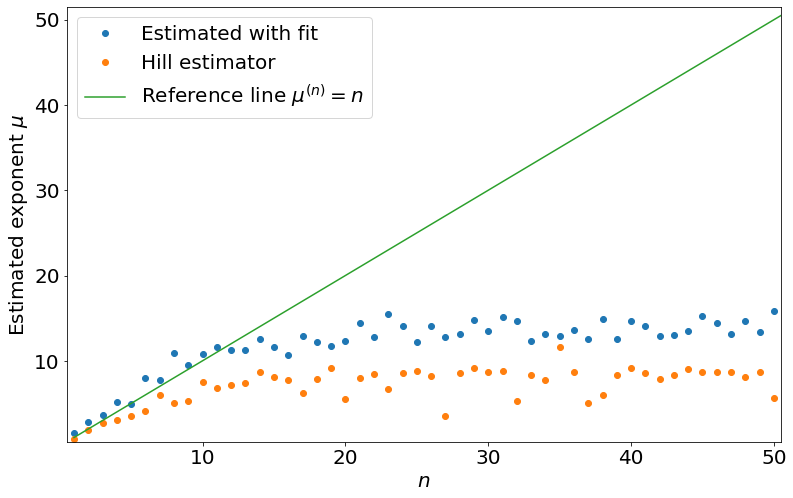

In [16]:
nmax = 50

plt.figure(figsize=(8*1.6,8))

plt.plot(n,(mu[:,0]),'o',label='Estimated with fit')
plt.plot(n,delta-1,'o',label='Hill estimator')
plt.plot(n,n,label='Reference line $\mu^{(n)}=n$')
plt.xlim([.5,nmax+.5])
plt.ylim([.5,nmax+1.5])



plt.legend();
plt.xlabel('$n$')
plt.ylabel('Estimated exponent $\mu$');

plt.savefig('GraphsR5/exponent.png')

----
### 6. Exponent and maximum plot

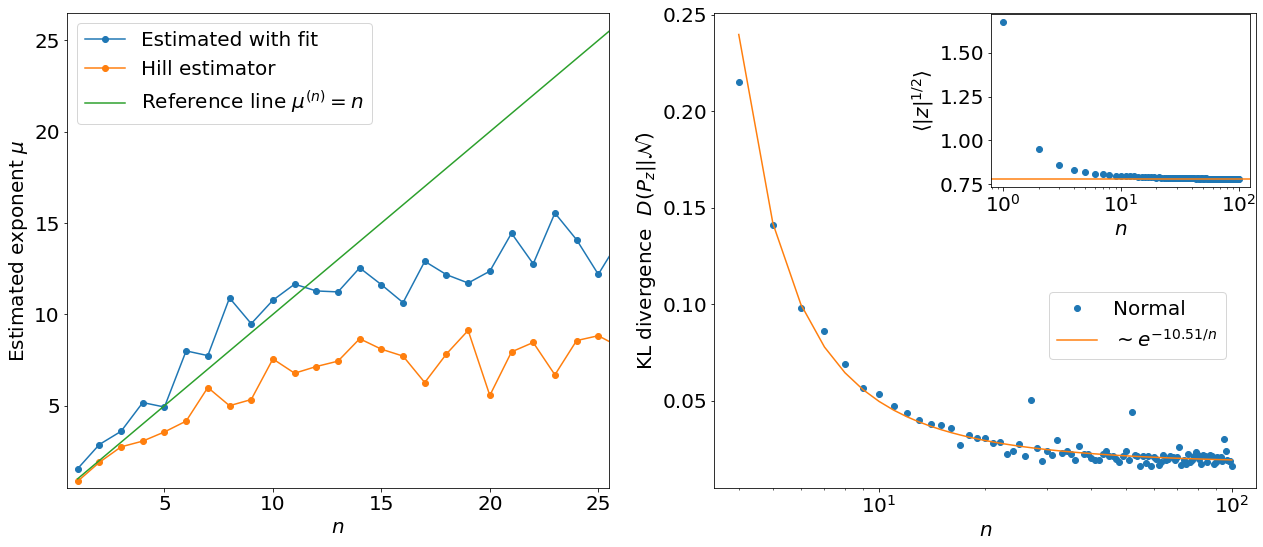

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,8))

nmax = 25

ax[0].plot(n,(mu[:,0]),'o-',label='Estimated with fit')
ax[0].plot(n,delta-1,'o-',label='Hill estimator')
ax[0].plot(n,n,label='Reference line $\mu^{(n)}=n$')
ax[0].set_xlim([.5,nmax+.5])
ax[0].set_ylim([.5,nmax+1.5])

ax[0].legend();
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('Estimated exponent $\mu$');


#fig, ax1 = plt.subplots(figsize=(9,8))

ax[1].plot(n[:],KL_norm[:],'o',label='Normal')
ax[1].plot(n[3:],np.exp(exp_fit[0]/n[3:])*np.exp(exp_fit[1]),label='$\sim e^{{{:.4}/n}}$'.format(-exp_fit[0]))

ax[1].set_xlabel('$n$')
ax[1].set_ylabel(r'KL divergence  $D(P_z\vert \vert \mathcal{N})$')
#plt.yscale('log')
ax[1].set_xscale('log')
ax[1].legend( bbox_to_anchor=(0.6, .25))


#ax1.legend(loc='upper left')


left, bottom, width, height = [0.776, 0.65, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(n,hm,'o');
#ax2.axhline(th_hm,c='tab:orange',label=r'$\mathbb{E}\left[\vert {X}\vert^{1/2}\right]$')
ax2.axhline(th_hm,c='tab:orange',label='Theoretical value')
ax2.set_xlabel('$n$')
ax2.set_ylabel(r'$\langle \vert z\vert^{1/2}\rangle $');
ax2.set_xscale('log')
#ax2.legend();


plt.tight_layout()
#plt.savefig('GraphsR5/KL_n.pdf')



### 7. Histogram with 2 regimes

In [21]:
ns=3

z4 = z[:,ns-1]
hist_z4 = np.histogram((z4-np.mean(z4)),bins=500,density=True)

x=np.linspace(-4,4,10000)
y=np.linspace(-10,10,10000)

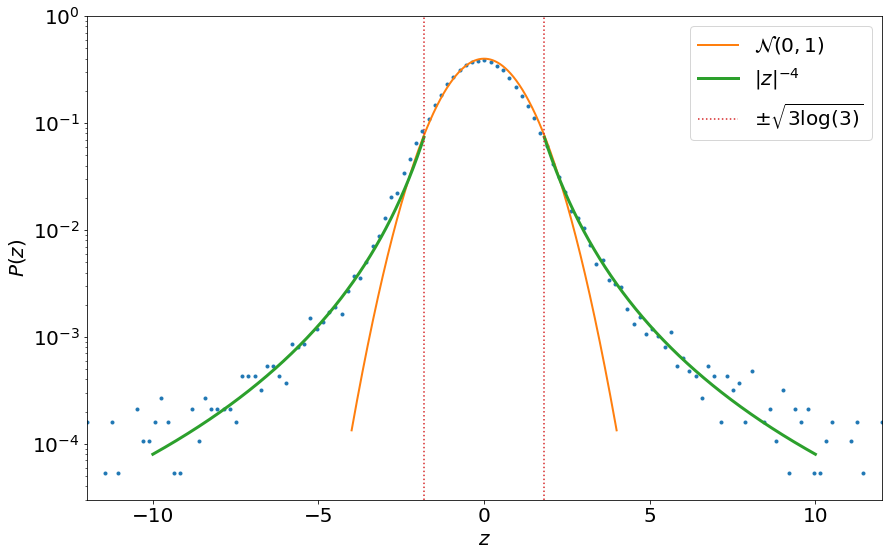

In [22]:
plt.figure(figsize=(8*1.6,8))
#plt.hist((z-np.mean(z))/np.std(z),bins=1000,density=True,label=r'$p(z/\sigma_0^2)$');

plt.plot(hist_z4[1][:-1],hist_z4[0],'.')
plt.plot(x,sc.norm.pdf(x,0,1),label=r'$\mathcal{N}(0,1)$',linewidth=2)
plt.plot(y[y>np.sqrt(ns*np.log(ns))],.8/np.abs(y[y>np.sqrt(ns*np.log(ns))])**(ns+1),linewidth=3,color='tab:green',label=r'$\vert z\vert^{{-{{{:}}}}}$'.format(ns+1))
plt.plot(y[y<-np.sqrt(ns*np.log(ns))],.8/np.abs(y[y<-np.sqrt(ns*np.log(ns))])**(ns+1),linewidth=3,color='tab:green')

plt.axvline(x=np.sqrt(ns*np.log(ns)),linestyle=':',color='tab:red',label='$\pm\sqrt{{3\log(3)}}$')
plt.axvline(x=-np.sqrt(ns*np.log(ns)),linestyle=':',color='tab:red')

plt.xlabel(r'$z$')
plt.ylabel(r'$P(z)$')
plt.legend();
#plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.xlim([-12,12]);
plt.ylim([3e-5,1]);



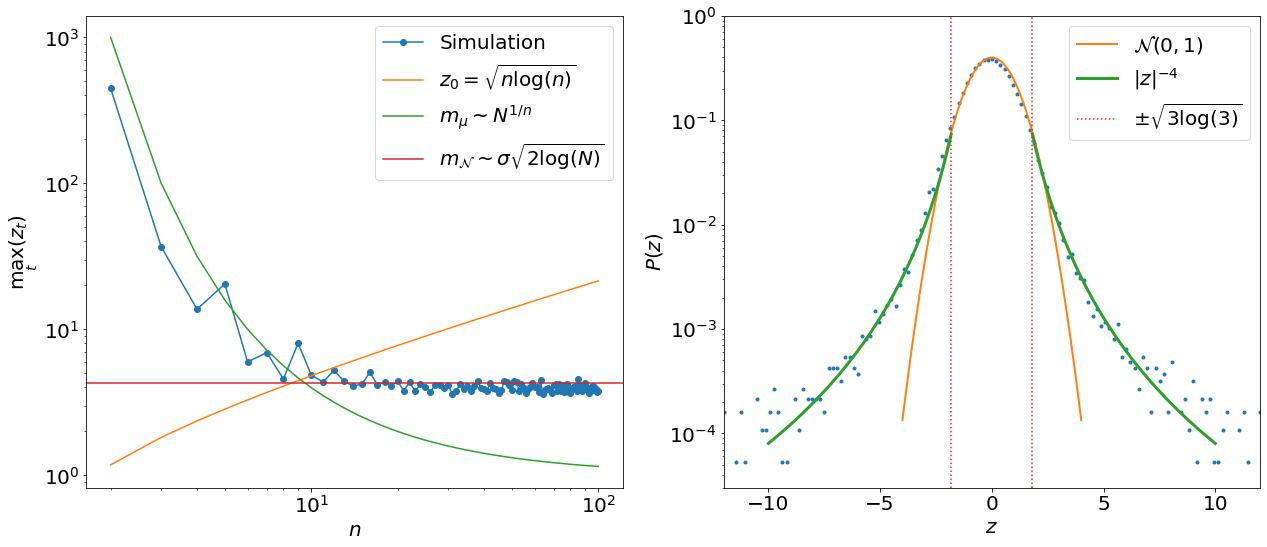

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,8))

nmax = 100
ax[0].plot(n[1:nmax],np.max((z[:,:nmax]),axis=0)[1:],'-o',label=r'Simulation')
ax[0].plot(n[1:nmax],np.sqrt(n[1:nmax]*np.log(n[1:nmax])),label=r'$z_0=\sqrt{n\log(n)}$')
ax[0].plot(n[1:nmax],(10*Niter)**(1/(n[1:nmax])),label=r'$m_\mu\sim N^{1/n}$')
#plt.plot(n[:nmax],2*np.sqrt(np.log(n[:nmax])),label=r'$\sqrt{\log{n}}$')

ax[0].axhline(np.sqrt(2*var*np.log(Niter)),c='tab:red', label=r'$m_\mathcal{N}\sim\sigma\sqrt{2\log(N)}$')

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_xlabel(r'$n$')
ax[0].set_ylabel(r'$\max_t(z_t)$');
ax[0].legend();


ax[1].plot(hist_z4[1][:-1],hist_z4[0],'.')
ax[1].plot(x,sc.norm.pdf(x,0,1),label=r'$\mathcal{N}(0,1)$',linewidth=2)
ax[1].plot(y[y>np.sqrt(ns*np.log(ns))],.8/np.abs(y[y>np.sqrt(ns*np.log(ns))])**(ns+1),linewidth=3,color='tab:green',label=r'$\vert z\vert^{{-{{{:}}}}}$'.format(ns+1))
ax[1].plot(y[y<-np.sqrt(ns*np.log(ns))],.8/np.abs(y[y<-np.sqrt(ns*np.log(ns))])**(ns+1),linewidth=3,color='tab:green')

ax[1].axvline(x=np.sqrt(ns*np.log(ns)),linestyle=':',color='tab:red',label='$\pm\sqrt{{3\log(3)}}$')
ax[1].axvline(x=-np.sqrt(ns*np.log(ns)),linestyle=':',color='tab:red')

ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$P(z)$')
ax[1].legend();
#ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_xlim([-12,12]);
ax[1].set_ylim([3e-5,1]);


plt.tight_layout();
#plt.savefig('GraphsR5/max_n_hist.pdf')